# Import library and read data file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input

In [2]:
# số timestep
n_timestep = 3
n_timepred = 3
# số thuộc tính mỗi timestep
n_feature = 9
# chia tập dữ liệu thành 75% để train, 12.5% để validation và 12.5% để test
train_val_test_rate = (0.75, 0.125, 0.125)

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/machine_learning/raw_data/dataset_new.csv', index_col='datetime', parse_dates=True)
unnoise_dataset = pd.read_csv('/content/drive/MyDrive/machine_learning/raw_data/unnoise_dataset.csv', index_col='datetime', parse_dates=True)

In [4]:
dataset.head()

,tempmax,tempmin,temp,dew,humidity,precip,windspeed,cloudcover,visibility
datetime,,,,,,,,,
2015-01-01,24.0,8.5,17.6,9.3,64.0,0.0,13.0,0.0,7.1
2015-01-02,22.0,11.0,16.3,9.4,65.5,0.0,13.9,0.0,7.7
2015-01-03,21.0,13.1,17.0,12.4,75.3,0.0,13.0,0.0,5.8
2015-01-04,22.3,16.9,19.3,16.1,81.9,0.0,16.8,1.0,6.2
2015-01-05,23.0,18.5,20.4,18.4,88.3,0.0,13.0,1.0,4.0


In [5]:
unnoise_dataset.head()

,tempmax,tempmin,temp,dew,humidity,precip,windspeed,cloudcover,visibility
datetime,,,,,,,,,
2015-01-01,22.0,8.5,16.3,9.3,64.0,0.0,13.0,0.0,7.1
2015-01-02,22.0,11.0,17.0,9.4,65.5,0.0,13.0,0.0,7.1
2015-01-03,22.0,13.1,17.0,12.4,75.3,0.0,13.9,0.0,6.2
2015-01-04,22.3,16.9,19.3,16.1,81.9,0.0,13.0,1.0,5.8
2015-01-05,23.0,18.5,20.4,16.1,88.0,0.0,13.0,1.0,4.2


# Generate Dataset

Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler()
scaled_unnoise_dataset = scaler.fit_transform(unnoise_dataset)

In [8]:
scaled_unnoise_dataset[:5]

array([[0.41139241, 0.07172996, 0.32384342, 0.37800687, 0.42926829,
        0.        , 0.21774194, 0.        , 0.47191011],
       [0.41139241, 0.17721519, 0.34875445, 0.3814433 , 0.45365854,
        0.        , 0.21774194, 0.        , 0.47191011],
       [0.41139241, 0.26582278, 0.34875445, 0.48453608, 0.61300813,
        0.        , 0.25403226, 0.        , 0.37078652],
       [0.42088608, 0.42616034, 0.43060498, 0.61168385, 0.7203252 ,
        0.        , 0.21774194, 1.        , 0.3258427 ],
       [0.44303797, 0.49367089, 0.46975089, 0.61168385, 0.8195122 ,
        0.        , 0.21774194, 1.        , 0.14606742]])

Split data

In [9]:
idx_train = int(train_val_test_rate[0] * len(scaled_unnoise_dataset))
idx_val = int((train_val_test_rate[0] + train_val_test_rate[1]) * len(scaled_unnoise_dataset))
train_set = np.array(scaled_unnoise_dataset[:idx_train])
val_set = np.array(scaled_unnoise_dataset[idx_train:idx_val])
test_set = np.array(scaled_unnoise_dataset[idx_val:])

In [10]:
train_set.shape, val_set.shape, test_set.shape

((2191, 9), (365, 9), (366, 9))

Timestep split

In [11]:
def timestep_split(data, n_step):
  X, y = [], []

  for i in range(len(data) - n_step):
    end_idx = i + n_step
    seq_X = data[i:end_idx]
    seq_y = data[end_idx]
    X.append(seq_X)
    y.append(seq_y)

  return np.array(X), np.array(y)

In [12]:
X_train, y_train = timestep_split(data=train_set, n_step=n_timestep)
X_val, y_val = timestep_split(data=val_set, n_step=n_timestep)
X_test, y_test = timestep_split(data=test_set, n_step=n_timestep)

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2188, 3, 9), (2188, 9), (362, 3, 9), (362, 9), (363, 3, 9), (363, 9))

# Build model

In [14]:
model = Sequential()
model.add(Input(shape=(n_timestep, n_feature), name='Input'))
model.add(SimpleRNN(units=64,
                    activation='tanh',
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    bias_initializer='zeros',
                    dropout=0.0,
                    recurrent_dropout=0.0,
                    return_sequences=True,
                    name='RNN_many_to_many'))
model.add(SimpleRNN(units=64,
                    activation='tanh',
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    bias_initializer='zeros',
                    dropout=0.0,
                    recurrent_dropout=0.0,
                    name='RNN_many_to_one'))
model.add(Dense(units=n_feature,
                activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                name='Output_layer'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                              beta_1=0.9,
                              beta_2=0.999,
                              epsilon=1e-08)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN_many_to_many (SimpleRNN  (None, 3, 64)            4736      
 )                                                               
                                                                 
 RNN_many_to_one (SimpleRNN)  (None, 64)               8256      
                                                                 
 Output_layer (Dense)        (None, 9)                 585       
                                                                 
Total params: 13,577
Trainable params: 13,577
Non-trainable params: 0
_________________________________________________________________


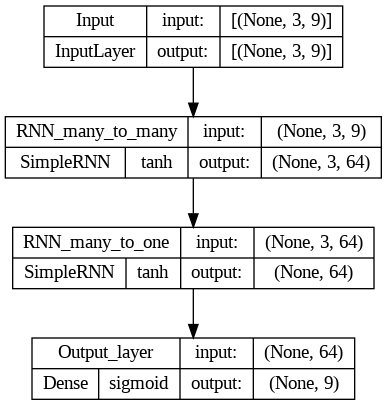

In [15]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

# Train

In [16]:
path = '/content/drive/MyDrive/machine_learning/model/RNN_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

In [17]:
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[checkpoint], batch_size=4,
          validation_data=(X_val, y_val), validation_batch_size=4)

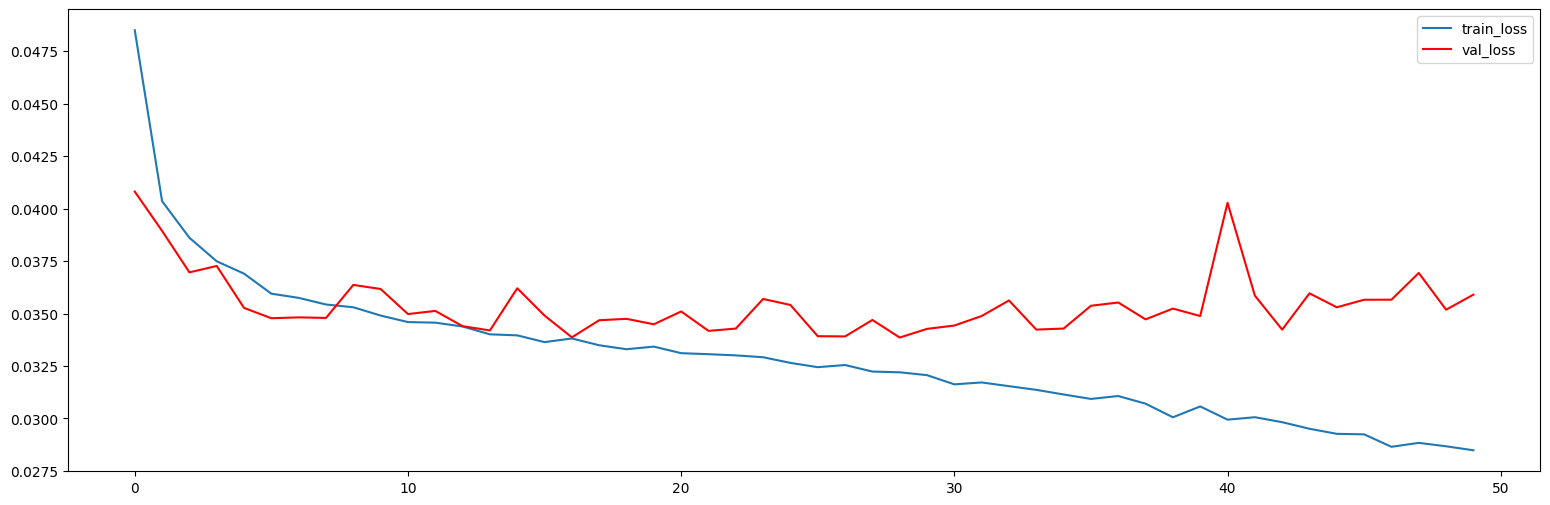

In [18]:
plt.figure(figsize=(19, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend()

# Evaluate

# 3 ngày dự đoán 1 ngày

In [56]:
model = keras.models.load_model('/content/drive/MyDrive/machine_learning/model/RNN_model.h5')

In [57]:
def predict(model, X, n_pred=1):
  pred = []
  for idx in range(0, len(X) - n_pred):
    X_i = X[idx][None]
    y_i = model.predict(X_i, verbose=0)
    pred.append(y_i)

  if len(X) % n_pred == 0:
    n = len(X) - n_pred
  else:
    n = len(X) - len(X)%n_pred
  return np.array(pred).reshape(n, n_feature)

In [58]:
y_predict = predict(model, X_test, n_pred=3)
y_predict = scaler.inverse_transform(y_predict)
y_unnoise = scaler.inverse_transform(y_test)

In [59]:
tmax_pred, tmin_pred, t_pred, dew_pred, humidity_pred, precip_pred, windspeed_pred, cloudcover_pred, visibility_pred = y_predict[:,0], y_predict[:,1], y_predict[:,2], y_predict[:,3], y_predict[:,4], y_predict[:,5], y_predict[:,6], y_predict[:,7], y_predict[:,8]

start_idx = n_timestep
end_idx = (len(y_test) - len(y_test)%n_timepred) if len(y_test)%n_timepred != 0 else (len(y_test) - n_timepred)

y_unnoise = y_unnoise[:end_idx, :]
tmax_unnoise, tmin_unnoise, t_unnoise, dew_unnoise, humidity_unnoise, precip_unnoise, windspeed_unnoise, cloudcover_unnoise, visibility_unnoise = y_unnoise[:,0], y_unnoise[:,1], y_unnoise[:,2], y_unnoise[:,3], y_unnoise[:,4], y_unnoise[:,5], y_unnoise[:,6], y_unnoise[:,7], y_unnoise[:,8]

y_real_test = np.array(dataset[idx_val:])
y_real_test = y_real_test[start_idx : end_idx+start_idx, : ]
tmax_real, tmin_real, t_real, dew_real, humidity_real, precip_real, windspeed_real, cloudcover_real, visibility_real = y_real_test[:,0], y_real_test[:,1], y_real_test[:,2], y_real_test[:,3], y_real_test[:,4], y_real_test[:,5], y_real_test[:,6], y_real_test[:,7], y_real_test[:,8]

In [60]:
y_real_test[:5]

array([[20.2, 13. , 16.7, 13.9, 84.8,  0. ,  7.6,  1. ,  4.8],
       [24.5, 16. , 20.2, 15.4, 75.5,  0. , 20.5,  1. ,  6.5],
       [24. , 17. , 20.4, 17.3, 83.4,  0. , 14.8,  0. ,  5.8],
       [25. , 19. , 21.3, 17.9, 81.3,  0. , 16.7,  0. ,  7.5],
       [24. , 19. , 21. , 16.9, 78. ,  0. , 22.3,  1. ,  8.1]])

In [61]:
y_predict[:5]

array([[2.0945726e+01, 1.5329057e+01, 1.8328909e+01, 1.3975041e+01,
        8.1483612e+01, 3.6817467e-01, 1.3301381e+01, 8.1791806e-01,
        7.4674945e+00],
       [2.3194412e+01, 1.6495781e+01, 1.9744999e+01, 1.4830424e+01,
        7.9652184e+01, 1.5668604e-01, 1.4156390e+01, 4.7014034e-01,
        5.7609711e+00],
       [2.4825174e+01, 1.7771439e+01, 2.0535437e+01, 1.7789984e+01,
        8.5401726e+01, 3.0652252e-01, 1.6427292e+01, 7.8930348e-01,
        5.9499178e+00],
       [2.6364874e+01, 1.7584438e+01, 2.1123867e+01, 1.7338673e+01,
        8.0433739e+01, 7.1847625e-02, 1.6968903e+01, 3.1628555e-01,
        7.0138230e+00],
       [2.6746298e+01, 1.9370243e+01, 2.2598368e+01, 1.8893364e+01,
        8.1993057e+01, 1.4525454e-01, 1.6076664e+01, 5.0547016e-01,
        7.2638845e+00]], dtype=float32)

In [62]:
from keras.metrics import mean_absolute_error

In [63]:
end_idx = len(dataset) - len(y_test)%n_timepred
start_idx = end_idx - len(y_predict)

Nhiệt độ cao nhất

In [64]:
tmax_mae_1 = float(mean_absolute_error(tmax_unnoise, tmax_pred))
tmax_mae_2 = float(mean_absolute_error(tmax_real, tmax_pred))
print('Độ lệch trung bình so với dữ liệu đã khử nhiễu là: {:.3f}'.format(tmax_mae_1))
print('Độ lệch trung bình so với dữ liệu thực tế là: {:.3f}'.format(tmax_mae_2))

Độ lệch trung bình so với dữ liệu đã khử nhiễu là: 1.346
Độ lệch trung bình so với dữ liệu thực tế là: 1.577


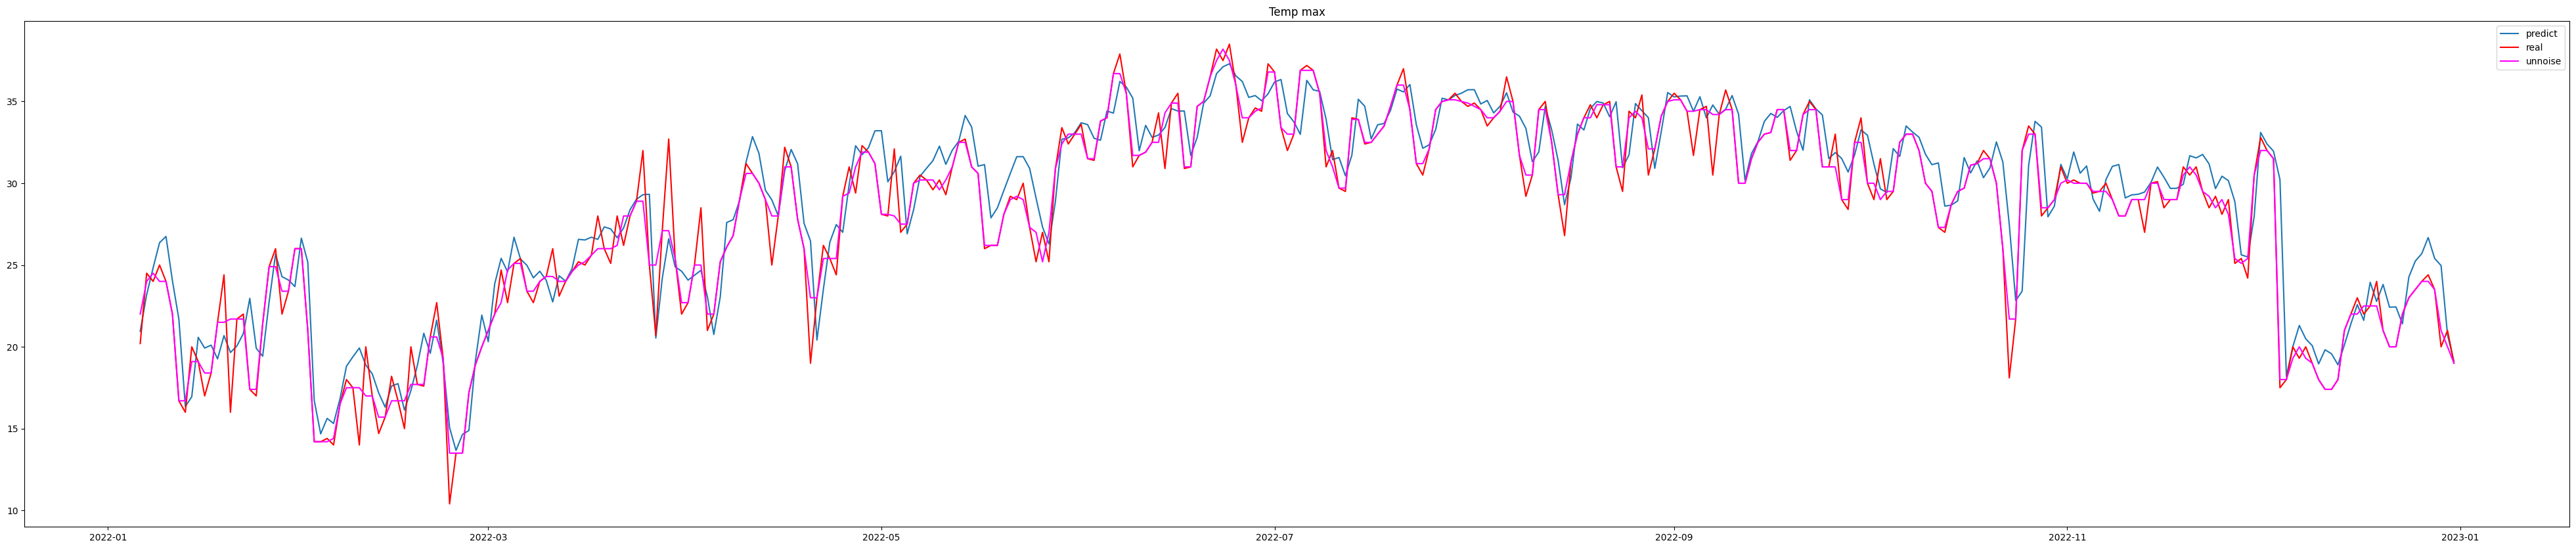

In [28]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, tmax_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, tmax_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, tmax_unnoise, c='magenta', label='unnoise')
plt.title('Temp max')
plt.legend();

Nhiệt độ thấp nhất

In [29]:
tmin_mae_1 = float(mean_absolute_error(tmin_unnoise, tmin_pred))
tmin_mae_2 = float(mean_absolute_error(tmin_real, tmin_pred))
print('Độ lệch trung bình  so với dữ liệu đã khử nhiễu là: {:.3f}'.format(tmin_mae_1))
print('Độ lệch trung bình  so với dữ liệu thực tế là: {:.3f}'.format(tmin_mae_2))

Độ lệch trung bình  so với dữ liệu đã khử nhiễu là: 0.878
Độ lệch trung bình  so với dữ liệu thực tế là: 1.022


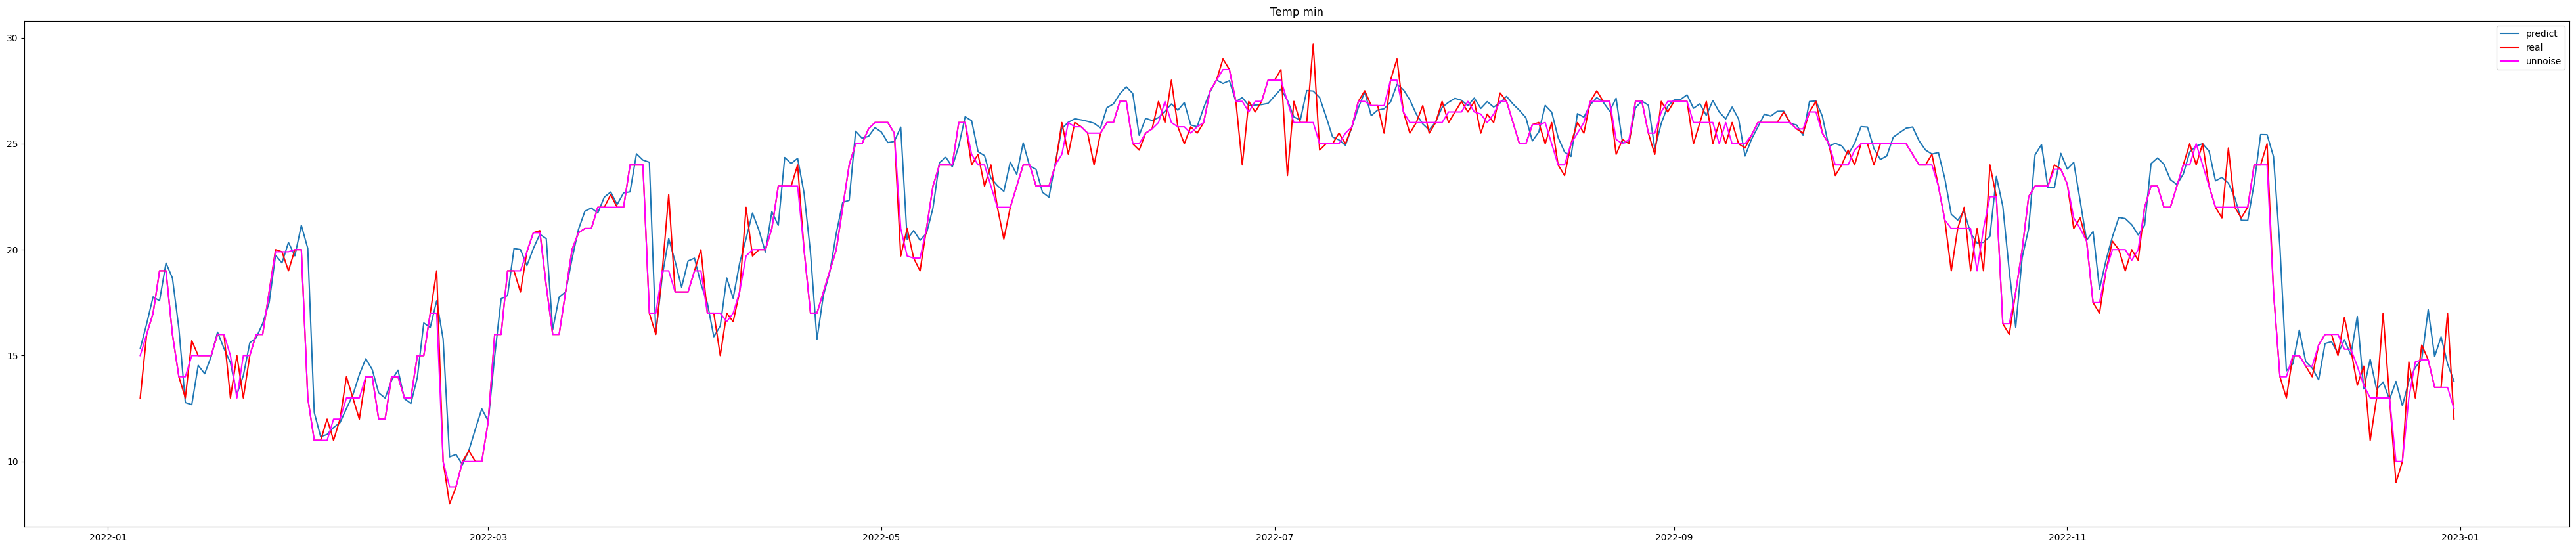

In [30]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, tmin_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, tmin_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, tmin_unnoise, c='magenta', label='unnoise')
plt.title('Temp min')
plt.legend();

Nhiệt độ trung bình

In [31]:
t_mae_1 = float(mean_absolute_error(t_unnoise, t_pred))
t_mae_2 = float(mean_absolute_error(t_real, t_pred))
print('Độ lệch trung bình so với dữ liệu đã khử nhiễu là: {:.3f}'.format(t_mae_1))
print('Độ lệch trung bình so với dữ liệu thực tế là: {:.3f}'.format(t_mae_2))

Độ lệch trung bình so với dữ liệu đã khử nhiễu là: 1.061
Độ lệch trung bình so với dữ liệu thực tế là: 1.162


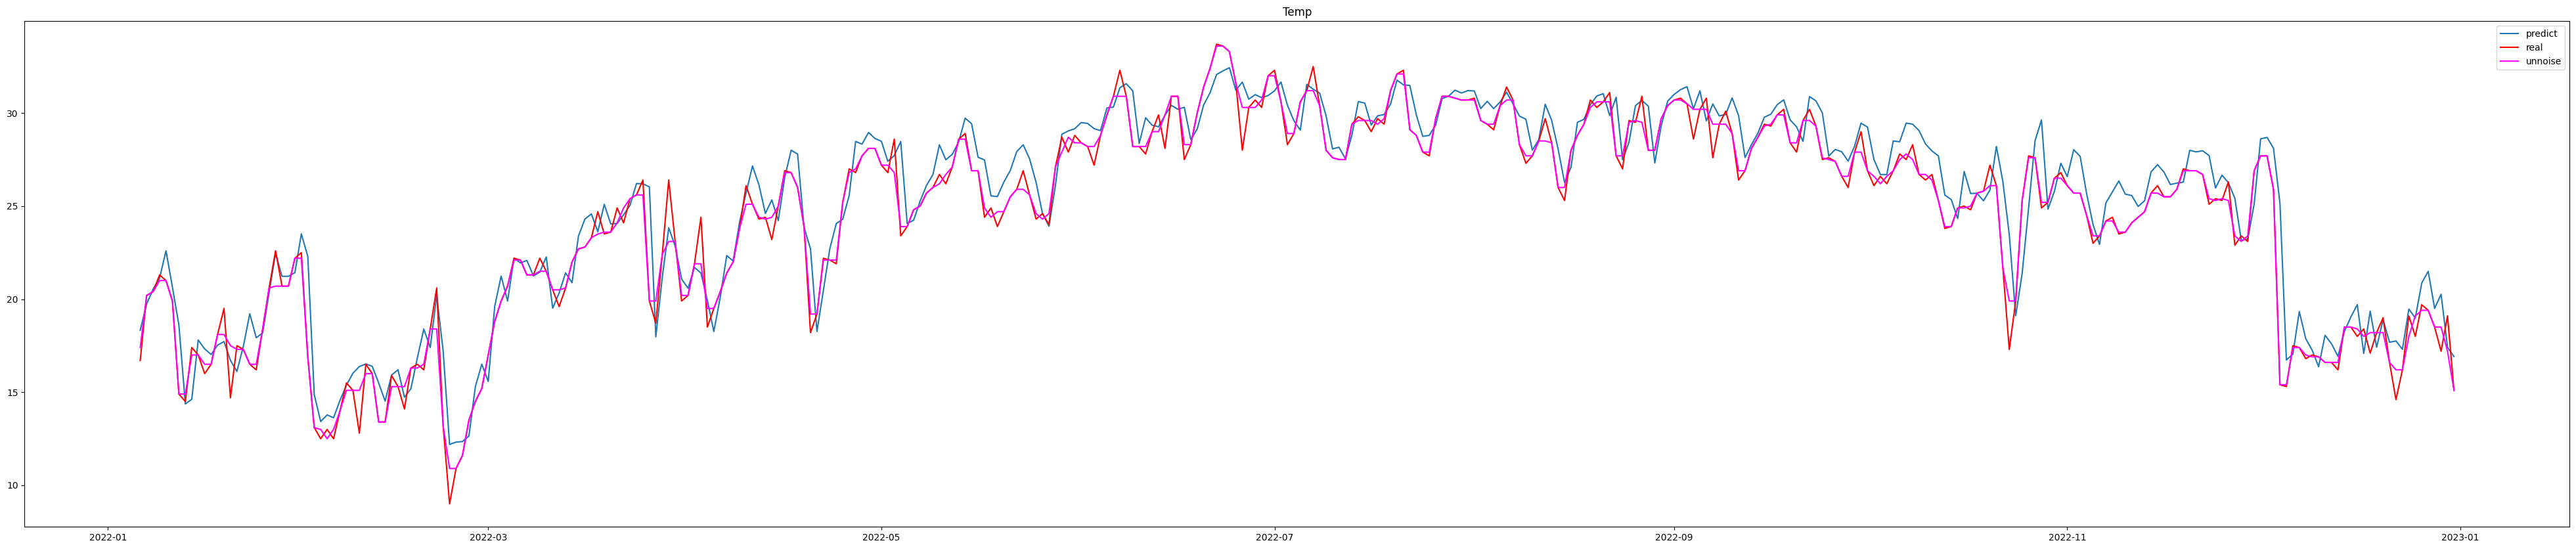

In [32]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, t_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, t_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, t_unnoise, c='magenta', label='unnoise')
plt.title('Temp')
plt.legend();

Điểm sương

In [65]:
dew_mae_1 = float(mean_absolute_error(dew_unnoise, dew_pred))
dew_mae_2 = float(mean_absolute_error(dew_real, dew_pred))
print('Độ lệch trung bình so với dữ liệu đã khử nhiễu là: {:.3f}'.format(dew_mae_1))
print('Độ lệch trung bình so với dữ liệu thực tế là: {:.3f}'.format(dew_mae_2))

Độ lệch trung bình so với dữ liệu đã khử nhiễu là: 1.145
Độ lệch trung bình so với dữ liệu thực tế là: 1.217


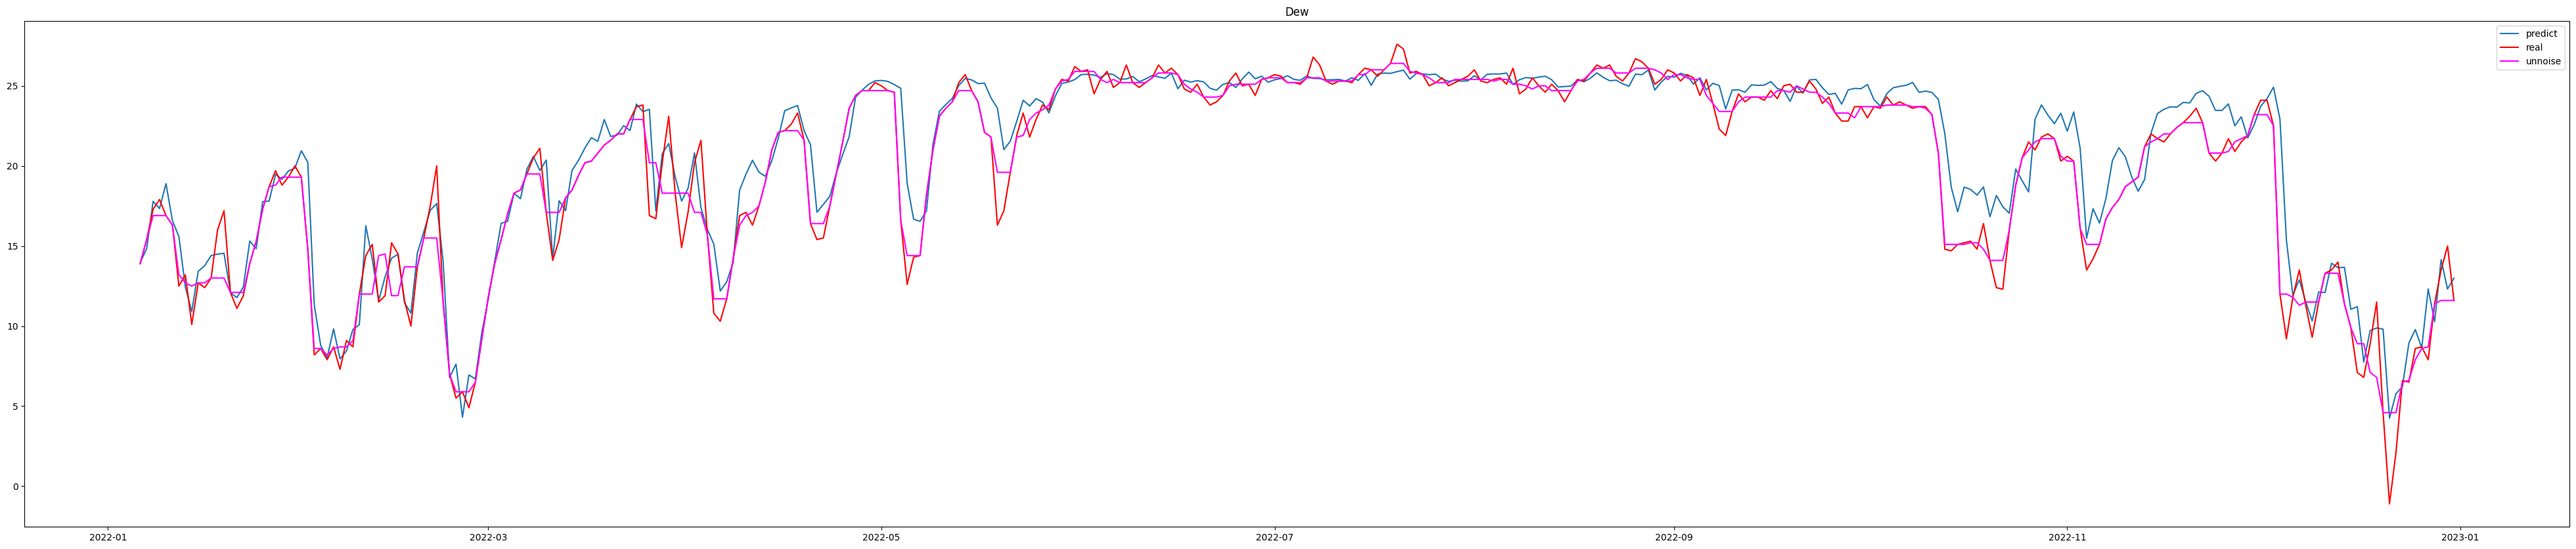

In [34]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, dew_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, dew_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, dew_unnoise, c='magenta', label='unnoise')
plt.title('Dew')
plt.legend();

Độ ẩm

In [35]:
humidity_mae_1 = float(mean_absolute_error(humidity_unnoise, humidity_pred))
humidity_mae_2 = float(mean_absolute_error(humidity_real, humidity_pred))
print('Độ lệch trung bình so với dữ liệu đã khử nhiễu là: {:.3f}'.format(humidity_mae_1))
print('Độ lệch trung bình so với dữ liệu thực tế là: {:.3f}'.format(humidity_mae_2))

Độ lệch trung bình so với dữ liệu đã khử nhiễu là: 3.468
Độ lệch trung bình so với dữ liệu thực tế là: 3.841


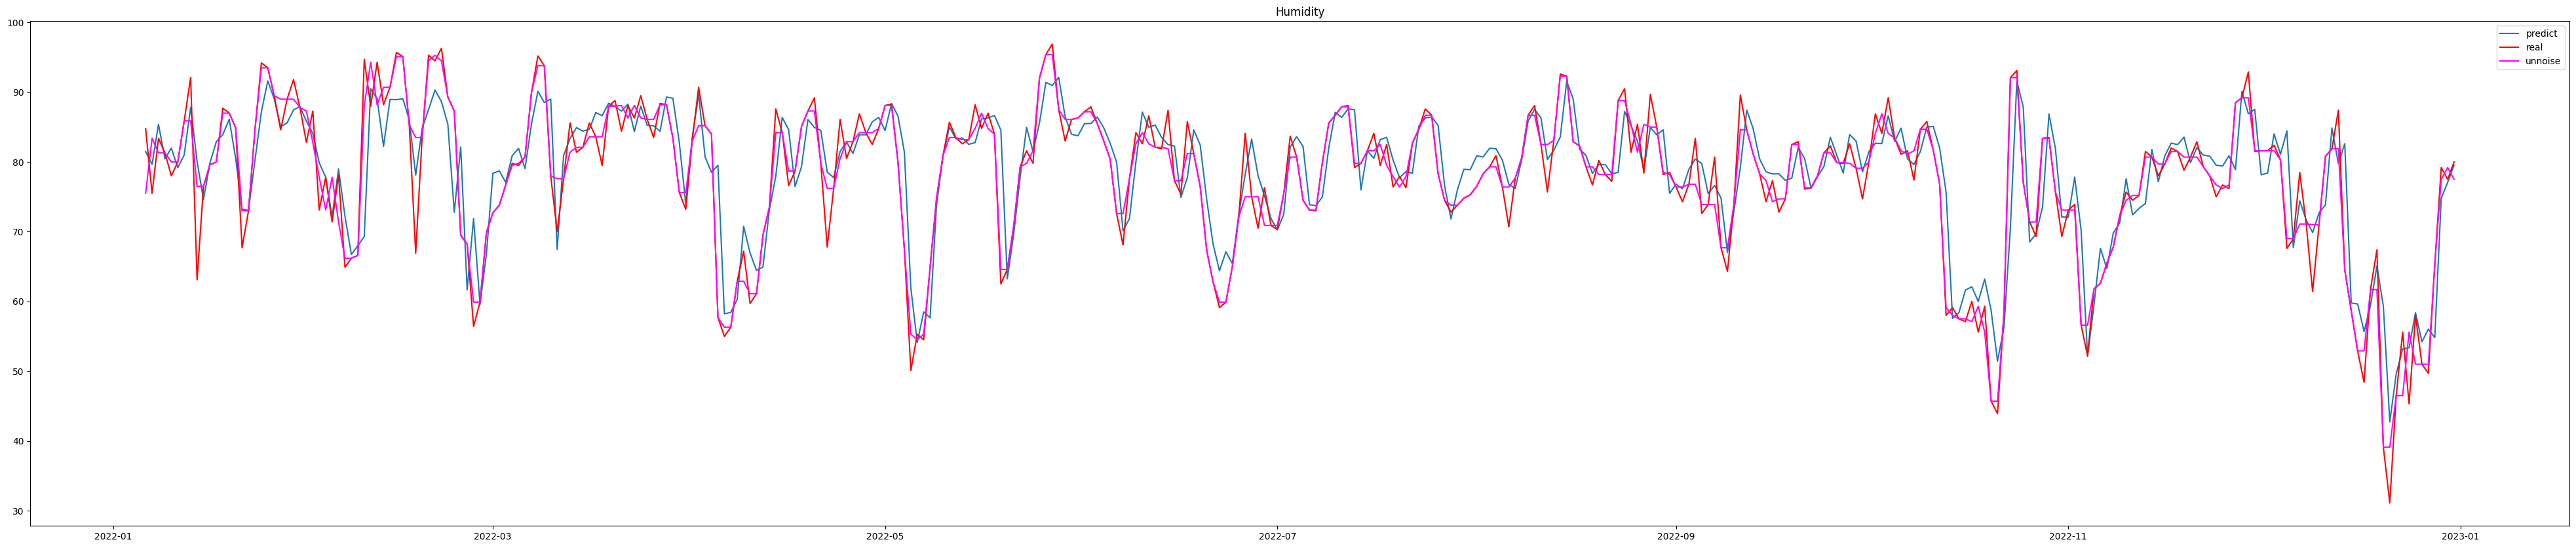

In [36]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, humidity_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, humidity_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, humidity_unnoise, c='magenta', label='unnoise')
plt.title('Humidity')
plt.legend();

Độ che phủ mây

In [66]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(cloudcover_real, cloudcover_pred)
cloudcover_accuracy = m.result().numpy()

In [67]:
print('Độ chính xác khi dự đoán độ che phủ mây: {:.2f}%'.format(cloudcover_accuracy*100))

Độ chính xác khi dự đoán độ che phủ mây: 79.17%


Tốc độ gió

In [39]:
windspeed_mae_1 = float(mean_absolute_error(windspeed_unnoise, windspeed_pred))
windspeed_mae_2 = float(mean_absolute_error(windspeed_real, windspeed_pred))
print('Độ lệch trung bình so với dữ liệu đã khử nhiễu là: {:.3f}'.format(windspeed_mae_1))
print('Độ lệch trung bình so với dữ liệu thực tế là: {:.3f}'.format(windspeed_mae_2))

Độ lệch trung bình so với dữ liệu đã khử nhiễu là: 1.789
Độ lệch trung bình so với dữ liệu thực tế là: 2.712


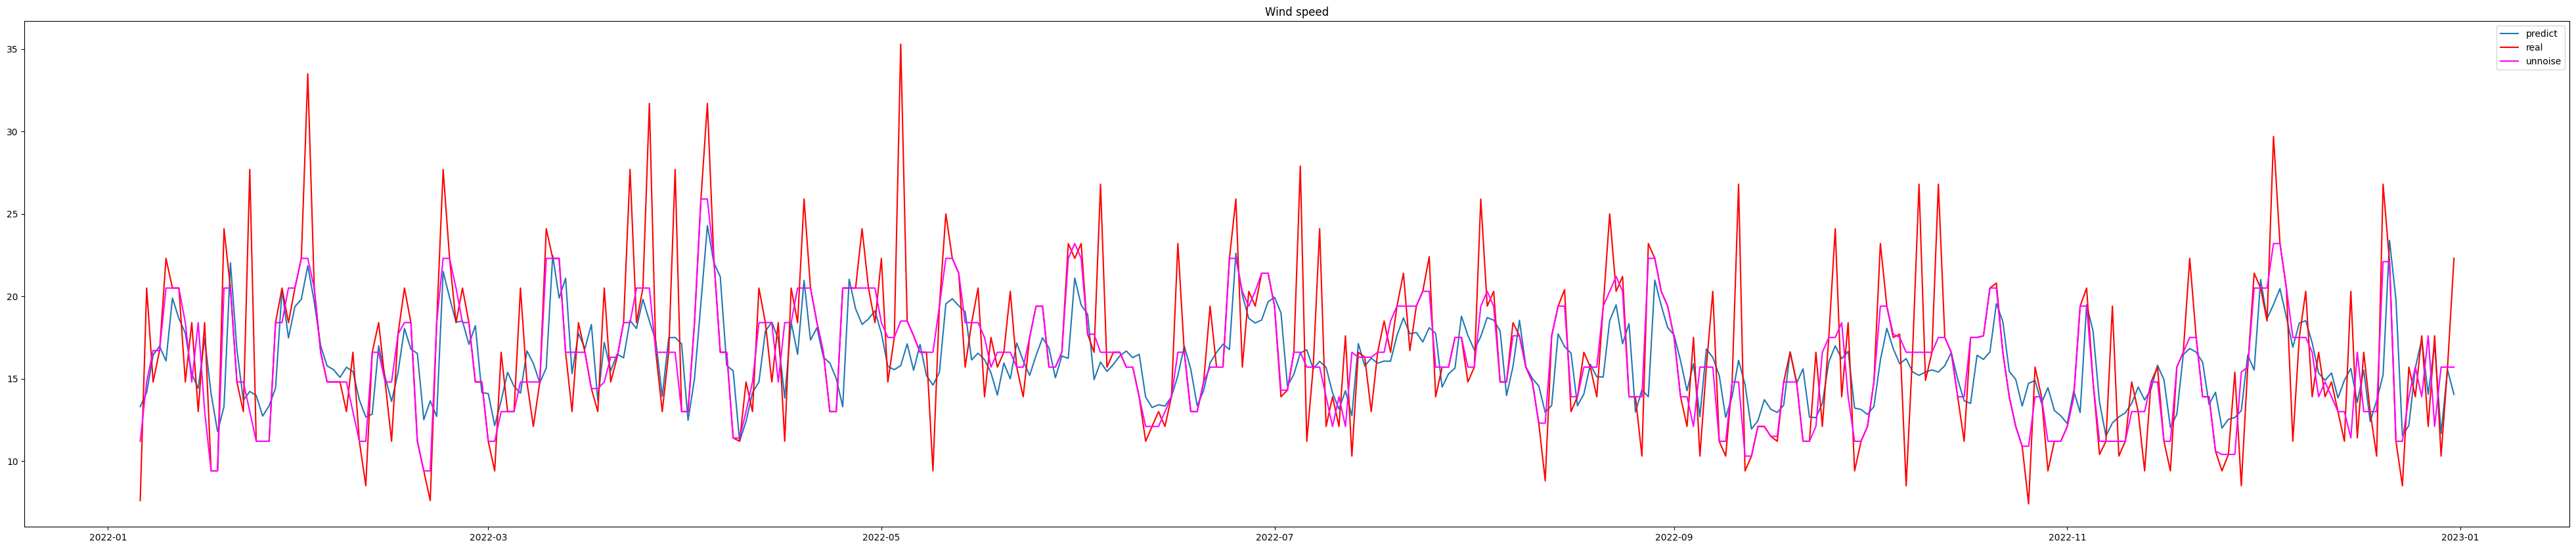

In [40]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, windspeed_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, windspeed_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, windspeed_unnoise, c='magenta', label='unnoise')
plt.title('Wind speed')
plt.legend();

Tầm nhìn

In [41]:
visibility_mae_1 = float(mean_absolute_error(visibility_unnoise, visibility_pred))
visibility_mae_2 = float(mean_absolute_error(visibility_real, visibility_pred))
print('Độ lệch trung bình so với dữ liệu đã khử nhiễu là: {:.3f}'.format(visibility_mae_1))
print('Độ lệch trung bình so với dữ liệu thực tế là: {:.3f}'.format(visibility_mae_2))

Độ lệch trung bình so với dữ liệu đã khử nhiễu là: 0.559
Độ lệch trung bình so với dữ liệu thực tế là: 0.693


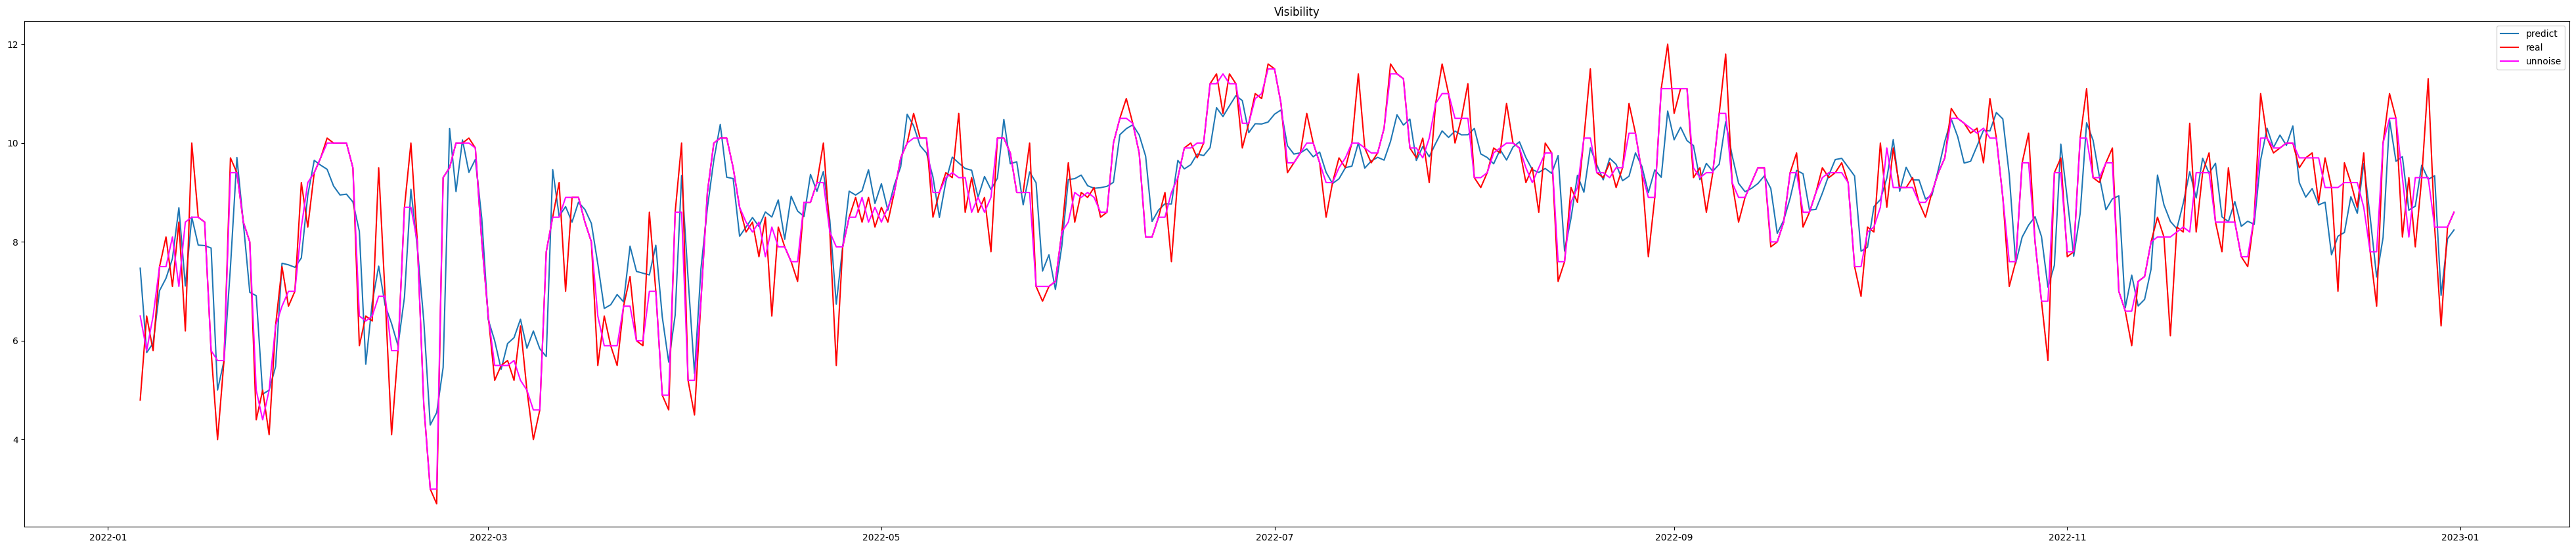

In [42]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, visibility_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, visibility_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, visibility_unnoise, c='magenta', label='unnoise')
plt.title('Visibility')
plt.legend();

In [43]:
BA_precip = keras.metrics.BinaryAccuracy(threshold=0.5)
BA_precip.update_state(precip_real, precip_pred)
R_Accuracy_precip = float(BA_precip.result())
print('Độ chính xác khi dự đoán mưa hay không: {:.2f}%'.format(R_Accuracy_precip*100))

Độ chính xác khi dự đoán mưa hay không: 83.06%


In [44]:
conclusion = pd.DataFrame({
    'Predict' : ['t_max', 't_min', 't_tb', 'dew', 'humidity', 'cloud cover', 'wind speed', 'visibility', 'precip'],
    'Vs_unnoise_data' : [tmax_mae_1, tmin_mae_1, t_mae_1, dew_mae_1, humidity_mae_1, cloudcover_accuracy, windspeed_mae_1, visibility_mae_1, R_Accuracy_precip],
    'Vs_real_data' : [tmax_mae_2, tmin_mae_2, t_mae_2, dew_mae_2, humidity_mae_2, cloudcover_accuracy, windspeed_mae_2, visibility_mae_2, R_Accuracy_precip]
})

In [45]:
conclusion

,Predict,Vs_unnoise_data,Vs_real_data
0,t_max,1.346059,1.577004
1,t_min,0.878386,1.021597
2,t_tb,1.060508,1.162313
3,dew,1.144651,1.217306
4,humidity,3.467568,3.840548
5,cloud cover,0.791667,0.791667
6,wind speed,1.789104,2.711812
7,visibility,0.559018,0.693230
8,precip,0.830556,0.830556


# 3 ngày dự đoán 3 ngày

In [46]:
model = keras.models.load_model('/content/drive/MyDrive/machine_learning/model/RNN_model.h5')

In [47]:
def predict(model, X, n_pred=1):
  pred = []

  for idx in range(0, len(X) - n_pred, n_pred):
    X_i = X[idx][None]
    for i in range(n_pred):
      y_i = model.predict(X_i, verbose=0)
      pred.append(y_i)
      if y_i[0][5] < 0.5:
        y_i[0][5] = 0
      else:
        y_i[0][5] = 1
      y_i[0][7] = round(y_i[0][7])

      X_i = np.append(X_i[0], y_i, axis=0)[None]
      X_i = X_i[:,1:,:]

  if len(X) % n_pred == 0:
    n = len(X) - n_pred
  else:
    n = len(X) - len(X)%n_pred
  return np.array(pred).reshape(n, n_feature)

In [48]:
y_predict = predict(model, X_test, n_pred=3)
y_predict = scaler.inverse_transform(y_predict)
y_unnoise = scaler.inverse_transform(y_test)

In [49]:
tmax_pred, tmin_pred, t_pred, dew_pred, humidity_pred, precip_pred, windspeed_pred, cloudcover_pred, visibility_pred = y_predict[:,0], y_predict[:,1], y_predict[:,2], y_predict[:,3], y_predict[:,4], y_predict[:,5], y_predict[:,6], y_predict[:,7], y_predict[:,8]

start_idx = n_timestep
end_idx = (len(y_test) - len(y_test)%n_timepred) if len(y_test)%n_timepred != 0 else (len(y_test) - n_timepred)

y_unnoise = y_unnoise[:end_idx, :]
tmax_unnoise, tmin_unnoise, t_unnoise, dew_unnoise, humidity_unnoise, precip_unnoise, windspeed_unnoise, cloudcover_unnoise, visibility_unnoise = y_unnoise[:,0], y_unnoise[:,1], y_unnoise[:,2], y_unnoise[:,3], y_unnoise[:,4], y_unnoise[:,5], y_unnoise[:,6], y_unnoise[:,7], y_unnoise[:,8]

y_real_test = np.array(dataset[idx_val:])
y_real_test = y_real_test[start_idx : end_idx+start_idx, : ]
tmax_real, tmin_real, t_real, dew_real, humidity_real, precip_real, windspeed_real, cloudcover_real, visibility_real = y_real_test[:,0], y_real_test[:,1], y_real_test[:,2], y_real_test[:,3], y_real_test[:,4], y_real_test[:,5], y_real_test[:,6], y_real_test[:,7], y_real_test[:,8]

In [50]:
from keras.metrics import mean_absolute_error

In [51]:
end_idx = len(dataset) - len(y_test)%n_timepred
start_idx = end_idx - len(y_predict)

In [52]:
# Nhiệt độ cao nhất
tmax_mae_1 = float(mean_absolute_error(tmax_unnoise, tmax_pred))
tmax_mae_2 = float(mean_absolute_error(tmax_real, tmax_pred))

# Nhiệt độ thấp nhất
tmin_mae_1 = float(mean_absolute_error(tmin_unnoise, tmin_pred))
tmin_mae_2 = float(mean_absolute_error(tmin_real, tmin_pred))

# Nhiệt độ trung bình
t_mae_1 = float(mean_absolute_error(t_unnoise, t_pred))
t_mae_2 = float(mean_absolute_error(t_real, t_pred))

# Điểm sương
dew_mae_1 = float(mean_absolute_error(dew_unnoise, dew_pred))
dew_mae_2 = float(mean_absolute_error(dew_real, dew_pred))

# Độ ẩm
humidity_mae_1 = float(mean_absolute_error(humidity_unnoise, humidity_pred))
humidity_mae_2 = float(mean_absolute_error(humidity_real, humidity_pred))

# Độ che phủ mây
m = tf.keras.metrics.AUC()
m.update_state(cloudcover_real, cloudcover_pred)
cloudcover_accuracy = m.result().numpy()

# Tốc độ gió
windspeed_mae_1 = float(mean_absolute_error(windspeed_unnoise, windspeed_pred))
windspeed_mae_2 = float(mean_absolute_error(windspeed_real, windspeed_pred))

# Tầm nhìn
visibility_mae_1 = float(mean_absolute_error(visibility_unnoise, visibility_pred))
visibility_mae_2 = float(mean_absolute_error(visibility_real, visibility_pred))

# Mưa
BA_precip = keras.metrics.BinaryAccuracy(threshold=0.5)
BA_precip.update_state(precip_real, precip_pred)
R_Accuracy_precip = float(BA_precip.result())

In [53]:
conclusion = pd.DataFrame({
    'Predict' : ['t_max', 't_min', 't_tb', 'dew', 'humidity', 'cloud cover', 'wind speed', 'visibility', 'precip'],
    'Vs_unnoise_data' : [tmax_mae_1, tmin_mae_1, t_mae_1, dew_mae_1, humidity_mae_1, cloudcover_accuracy, windspeed_mae_1, visibility_mae_1, R_Accuracy_precip],
    'Vs_real_data' : [tmax_mae_2, tmin_mae_2, t_mae_2, dew_mae_2, humidity_mae_2, cloudcover_accuracy, windspeed_mae_2, visibility_mae_2, R_Accuracy_precip]
})

In [54]:
conclusion

,Predict,Vs_unnoise_data,Vs_real_data
0,t_max,2.272189,2.508318
1,t_min,1.462296,1.601900
2,t_tb,1.818193,1.925309
3,dew,1.741991,1.897124
4,humidity,5.442792,6.053999
5,cloud cover,0.641929,0.641929
6,wind speed,2.510871,3.447388
7,visibility,0.788764,0.922988
8,precip,0.811111,0.811111
